In [1]:
import requests
import folium
import geopandas as gpd
from shapely.geometry import shape
from pyproj import CRS
import json
import os
import geovoronoi

In [2]:
shp_files = {
"air_bersih" : r"D:\WORK\COURSE\MAPID\SESSION 2_PYTHON FOR SPATIAL DATA\MEET 4\AIR_BERSIH.shp",
"harga_lahan" : r"D:\WORK\COURSE\MAPID\SESSION 2_PYTHON FOR SPATIAL DATA\MEET 4\HARGA_LAHAN.shp",
"transportasi" : r"D:\WORK\COURSE\MAPID\SESSION 2_PYTHON FOR SPATIAL DATA\MEET 4\TRANSPORTASI.shp",
"kepadatan_penduduk" : r"D:\WORK\COURSE\MAPID\SESSION 2_PYTHON FOR SPATIAL DATA\MEET 4\KEPADATAN_PDDK.shp"
}
gdfs = {}

for key, path in shp_files.items():
    try:
        gdf=gpd.read_file(path)
        gdfs[key] = gdf
        print(f"Berhasil membaca: {os.path.basename(path)}")
    except Exception as e:
        print(f"Gagal membaca {path}: {e}")


Berhasil membaca: AIR_BERSIH.shp
Berhasil membaca: HARGA_LAHAN.shp
Berhasil membaca: TRANSPORTASI.shp
Berhasil membaca: KEPADATAN_PDDK.shp


In [3]:
for key, gdf in gdfs.items():
    for col in gdf.columns:
        if gdf[col].dtype == 'O':
            gdf[col] = gdf[col].fillna('TIDAK DIKETAHUI')
        else:
            gdf[col] = gdf[col].fillna(0)
    if gdf.crs is None or gdf.crs.to_epsg() !=4326:
        gdf.set_crs(epsg=4326, inplace=True)
    gdfs[key] = gdf
print('Semua data sudah dicek dan disesuaikan')

Semua data sudah dicek dan disesuaikan


In [5]:
for key, gdf in gdfs.items():
    m = folium.Map(location= [-7.787 ,110.374], zoom_start=13)
    folium.GeoJson(gdf).add_to(m)
    folium.LayerControl().add_to(m)
    display(m)
    print(f"Peta untuk variabel: {key}")

Peta untuk variabel: air_bersih


Peta untuk variabel: harga_lahan


Peta untuk variabel: transportasi


Peta untuk variabel: kepadatan_penduduk


In [13]:
print(gdfs['kepadatan_penduduk'].head())

  KETERANGAN                                           geometry
0     TINGGI  POLYGON ((110.37745 -7.78803, 110.37745 -7.787...
1     TINGGI  POLYGON ((110.37979 -7.78599, 110.37979 -7.785...
2     SEDANG  POLYGON ((110.36984 -7.78396, 110.36984 -7.783...
3     SEDANG  POLYGON ((110.36707 -7.78623, 110.36707 -7.785...
4     RENDAH  POLYGON ((110.36917 -7.79145, 110.36917 -7.791...


In [14]:
for key in gdfs.keys():
    gdfs[key] = gdfs[key][['KETERANGAN', 'geometry']].copy()
    gdfs[key] = gdfs[key].rename(
        columns={'KETERANGAN': f'KETERANGAN_{key}'}
    )

In [16]:
print(gdfs['air_bersih'].head())

  KETERANGAN_air_bersih                                           geometry
0                  BAIK  POLYGON ((110.37745 -7.78803, 110.37745 -7.787...
1                  BAIK  POLYGON ((110.37979 -7.78599, 110.37979 -7.785...
2                SEDANG  POLYGON ((110.36984 -7.78396, 110.36984 -7.783...
3                SEDANG  POLYGON ((110.36707 -7.78623, 110.36707 -7.785...
4                 BURUK  POLYGON ((110.36917 -7.79145, 110.36917 -7.791...


In [17]:
for key in gdfs.keys():
    if 'ID' in gdfs[key].columns:
        gdfs[key] = gdfs[key].drop(columns=['ID'])

gdf_list = [
    gdfs['kepadatan_penduduk'],
    gdfs['air_bersih'],
    gdfs['transportasi'],
    gdfs['harga_lahan'],
]

def overlay_multiple(gdf_list):
    result = gdf_list[0]
    for gdf in gdf_list[1:]:
        if not gdf.empty:
            result = gpd.overlay(result, gdf, how='intersection')
            result = result[result.is_valid]
    return result

gdf_intersect = overlay_multiple(gdf_list)
print(f"Jumlah area hasil intersect: {len(gdf_intersect)}")

Jumlah area hasil intersect: 8


In [18]:
print("Kolom hasil intersect: ", gdf_intersect.head())

Kolom hasil intersect:    KETERANGAN_kepadatan_penduduk KETERANGAN_air_bersih KETERANGAN_transportasi  \
0                        TINGGI                  BAIK                    BAIK   
1                        TINGGI                  BAIK                   BURUK   
2                        SEDANG                SEDANG                  SEDANG   
3                        SEDANG                SEDANG                    BAIK   
4                        RENDAH                 BURUK                   BURUK   

  KETERANGAN_harga_lahan                                           geometry  
0               47000000  POLYGON ((110.37798 -7.78803, 110.37745 -7.788...  
1               50000000  POLYGON ((110.38038 -7.78599, 110.37979 -7.785...  
2               25000000  POLYGON ((110.37043 -7.78396, 110.36984 -7.783...  
3               37000000  POLYGON ((110.36762 -7.78623, 110.36707 -7.786...  
4               12000000  POLYGON ((110.36956 -7.79145, 110.36917 -7.791...  


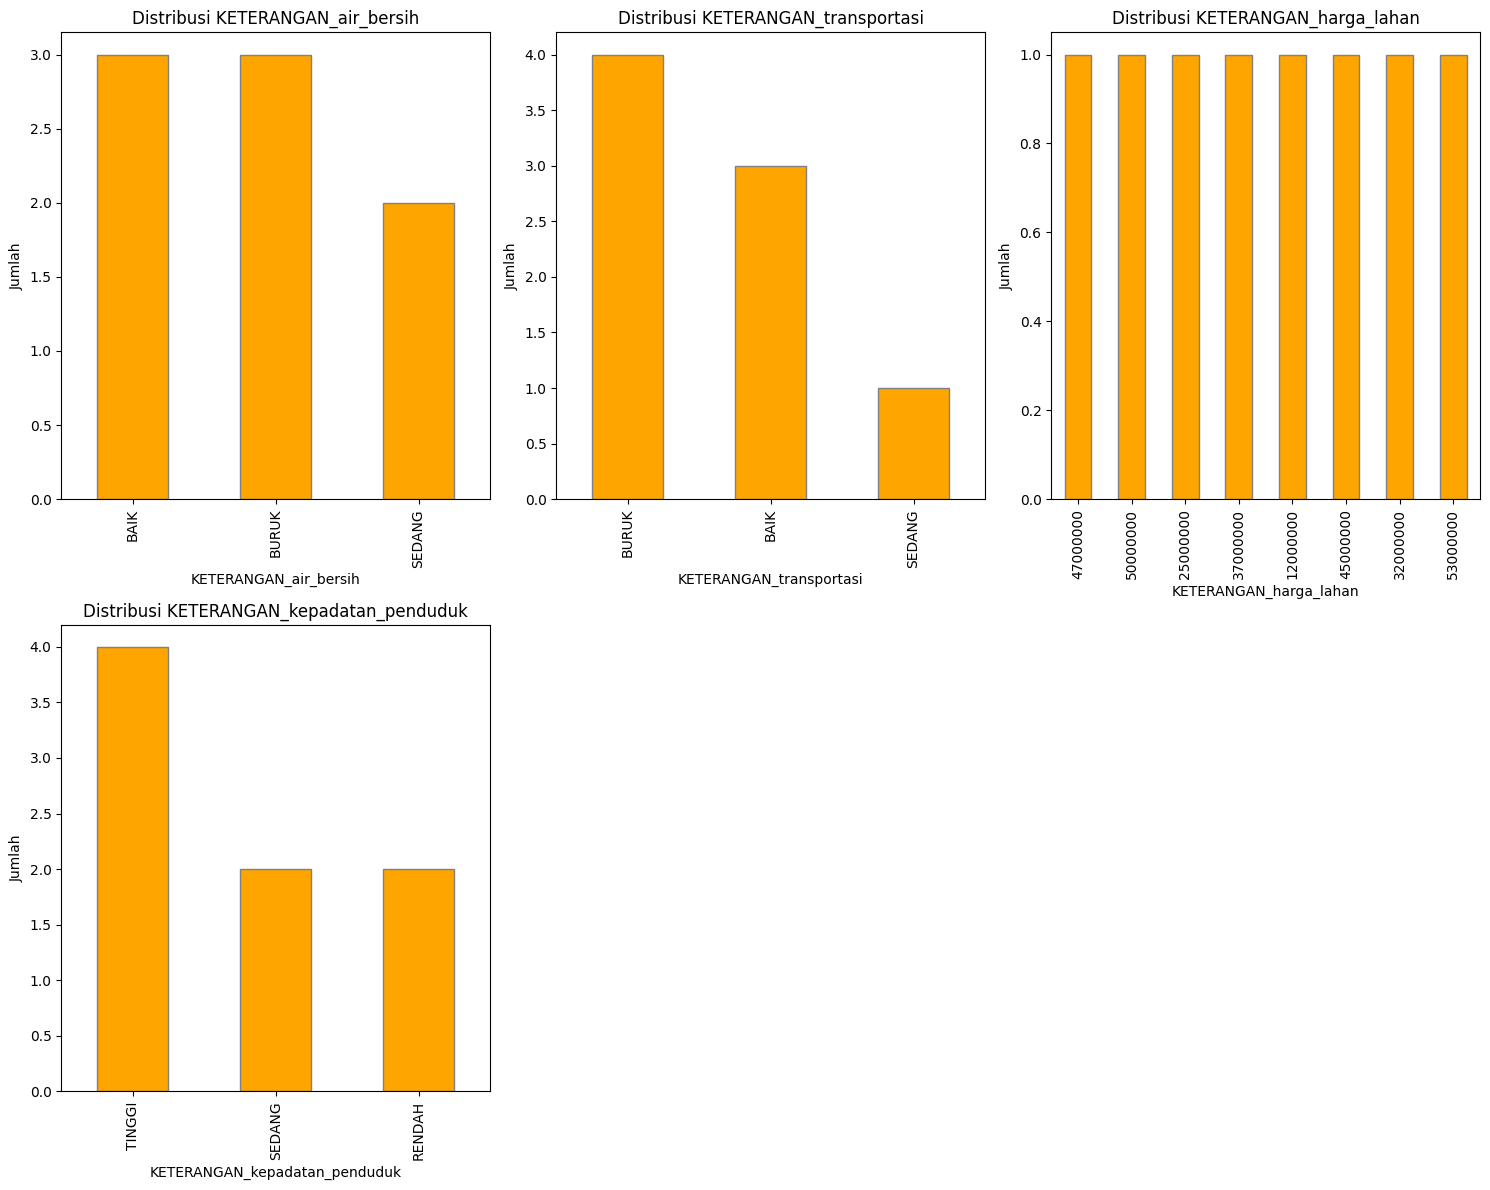

In [21]:
import matplotlib.pyplot as plt

kategori_cols = [
    'KETERANGAN_air_bersih', 'KETERANGAN_transportasi', 
    'KETERANGAN_harga_lahan', 'KETERANGAN_kepadatan_penduduk'
]

plt.figure(figsize=(15,12))
for i, col in enumerate(kategori_cols, 1):
    if col in gdf_intersect.columns:
        plt.subplot(2, 3, i)
        gdf_intersect[col].value_counts().plot(kind='bar', color='orange', edgecolor='gray')
        plt.title(f"Distribusi {col}")
        plt.xlabel(col)
        plt.ylabel('Jumlah')
plt.tight_layout()
plt.show()

In [37]:
import pandas as pd

# Pastikan semua jadi string dulu
gdf_intersect['KETERANGAN_harga_lahan'] = gdf_intersect['KETERANGAN_harga_lahan'].astype(str)

# Hapus semua karakter selain angka
gdf_intersect['KETERANGAN_harga_lahan'] = gdf_intersect['KETERANGAN_harga_lahan'].str.replace(r'[^0-9]', '', regex=True)

# Convert ke numeric
gdf_intersect['KETERANGAN_harga_lahan'] = pd.to_numeric(gdf_intersect['KETERANGAN_harga_lahan'], errors='coerce')

In [39]:
print(gdf_intersect['KETERANGAN_harga_lahan'].head())

0    47000000
1    50000000
2    25000000
3    37000000
4    12000000
Name: KETERANGAN_harga_lahan, dtype: int64


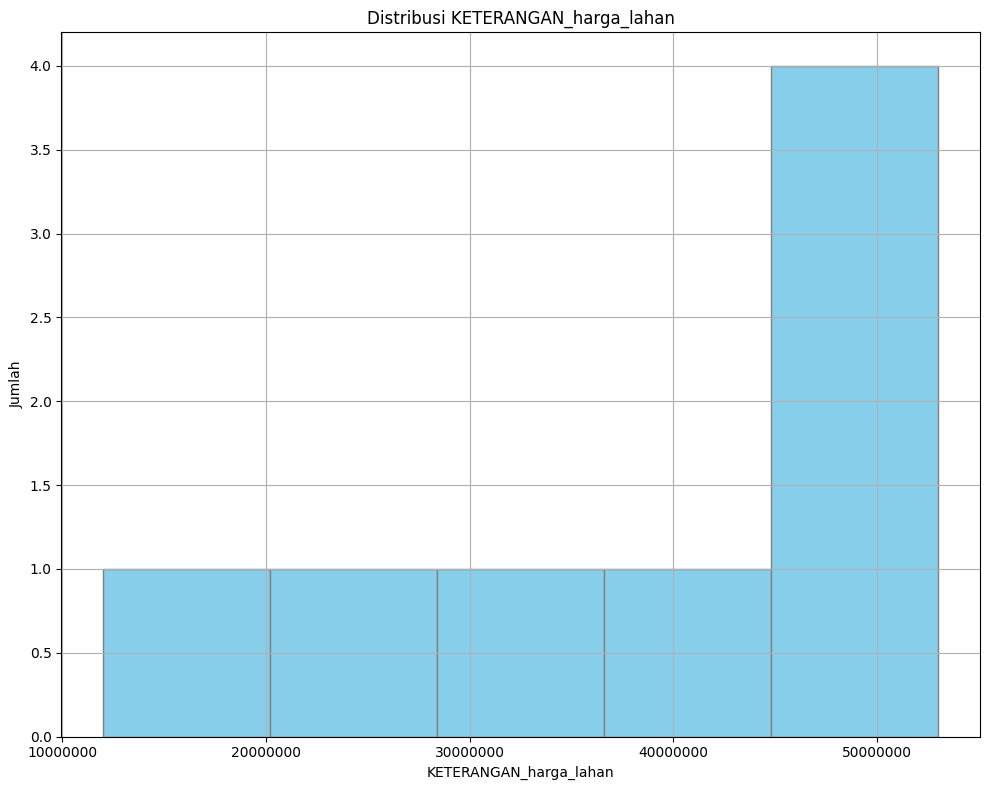

In [41]:
numerik_cols = []
if 'KETERANGAN_harga_lahan' in gdf_intersect.columns:
    numerik_cols.append('KETERANGAN_harga_lahan')

plt.figure(figsize=(10,8))
for i, col in enumerate(numerik_cols, 1):
    plt.subplot(1, len(numerik_cols), i)
    gdf_intersect[col].hist(bins=5, color='skyblue', edgecolor='gray')
    plt.title(f"Distribusi {col}")
    plt.xlabel(col)
    plt.ylabel('Jumlah')
    plt.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()

In [50]:
import pandas as pd

def skoring(row):
    skor = 0
    # Aturan skoring (bisa disesuaikan)
    skor += {"RENDAH": 1, "SEDANG": 2, "TINGGI": 3}.get(str(row.get("KETERANGAN_kepadatan_penduduk", "")).upper(), 0)
    skor += {"BURUK": 1, "SEDANG": 2, "BAIK": 3}.get(str(row.get("KETERANGAN_air_bersih", "")).upper(), 0)
    skor += {"BURUK": 1, "SEDANG": 2, "BAIK": 3}.get(str(row.get("KETERANGAN_transportasi", "")).upper(), 0)
    harga = row.get("KETERANGAN_harga_lahan", 0)
    skor += 3 if harga < 25000000 else 2 if harga < 35000000 else 1
    return skor

# Hitung skor total untuk setiap baris
gdf_intersect['SKOR_TOTAL'] = gdf_intersect.apply(skoring, axis=1)

# Klasifikasi kesesuaian lokasi
gdf_intersect['KESESUAIAN'] = pd.cut(
    gdf_intersect['SKOR_TOTAL'],
    bins=[0, 3, 6, 10],  # Interval: 0-10=RENDAH, 11-16=SEDANG, 17-24=TINGGI
    labels=['RENDAH', 'SEDANG', 'TINGGI'],
    include_lowest=True
)

# Lihat hasil 10 baris pertama
print(gdf_intersect[['SKOR_TOTAL', 'KESESUAIAN']].head(10))

   SKOR_TOTAL KESESUAIAN
0          10     TINGGI
1           8     TINGGI
2           8     TINGGI
3           8     TINGGI
4           6     SEDANG
5           6     SEDANG
6           9     TINGGI
7           6     SEDANG


In [51]:
import folium
import branca.colormap as cm

label_to_color = {'RENDAH': 'red', 'SEDANG': 'orange', 'TINGGI': 'green'}

def style_function(feature):
    kategori = feature['properties'].get('KESESUAIAN', 'gray')
    return{
        'fillColor': label_to_color.get(kategori, 'gray'),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.5
    }

m = folium.Map(location=[-7.787 ,110.374], zoom_start=15)

folium.GeoJson(
    gdf_intersect,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['SKOR_TOTAL', 'KESESUAIAN'])
).add_to(m)

colormap = cm.StepColormap(
    colors=['red', 'orange', 'green'],
    vmin=0, vmax=2,
    index=[0,1,2,3],
    caption='Kesesuaian Lokasi'
)
colormap.add_to(m)

m

In [52]:
output_dir = r"D:\WORK\COURSE\MAPID\SESSION 2_PYTHON FOR SPATIAL DATA\MAPID_WEBGIS_BOOTCAMP\labs\hasil_analisis_rumahsakit.geojson"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "hasil_analisis_rumahsakit.geojson")
gdf_intersect.to_file(output_path, driver='GeoJSON')
print(f"Hasil analisis berhasil disimpan di: {output_path}")

Hasil analisis berhasil disimpan di: D:\WORK\COURSE\MAPID\SESSION 2_PYTHON FOR SPATIAL DATA\MAPID_WEBGIS_BOOTCAMP\labs\hasil_analisis_rumahsakit.geojson\hasil_analisis_rumahsakit.geojson


In [53]:
# Temukan skor total maksimum
max_skor = gdf_intersect['SKOR_TOTAL'].max()

# Filter lokasi dengan skor total maksimum
lokasi_optimal = gdf_intersect[gdf_intersect['SKOR_TOTAL'] == max_skor]
print(f"Jumlah lokasi optimal (skor tertinggi): {len(lokasi_optimal)}")
print("Atribut lokasi optimal:")
print(lokasi_optimal[['SKOR_TOTAL', 'KETERANGAN_harga_lahan', 'KETERANGAN_transportasi', 
                      'KETERANGAN_air_bersih', 
                      'KETERANGAN_kepadatan_penduduk']])

Jumlah lokasi optimal (skor tertinggi): 1
Atribut lokasi optimal:
   SKOR_TOTAL  KETERANGAN_harga_lahan KETERANGAN_transportasi  \
0          10                47000000                    BAIK   

  KETERANGAN_air_bersih KETERANGAN_kepadatan_penduduk  
0                  BAIK                        TINGGI  


In [55]:
# Buat peta
m_optimal = folium.Map(location=[-7.787 ,110.374], zoom_start=15)

# Fungsi style khusus lokasi optimal
def style_optimal(feature):
    return {
        'fillColor': 'lime',
        'color': 'blue',
        'weight': 3,
        'fillOpacity': 0.7
    }

# Tambahkan seluruh GeoDataFrame lokasi optimal sekaligus
folium.GeoJson(
    lokasi_optimal,
    style_function=style_optimal,
    tooltip=folium.GeoJsonTooltip(fields=['SKOR_TOTAL', 'KESESUAIAN'])
).add_to(m_optimal)

folium.LayerControl().add_to(m_optimal)
m_optimal  # Tampilkan di Jupyter Notebook

In [56]:
# Buffer 500 meter dari lokasi optimal (sekitar 0.005 derajat pada EPSG:4326)
lokasi_optimal['buffer_500m'] = lokasi_optimal.geometry.buffer(0.005)

# Statistik tambahan
print("Statistik lokasi optimal:")
print(lokasi_optimal.describe(include='all'))

Statistik lokasi optimal:
       KETERANGAN_kepadatan_penduduk KETERANGAN_air_bersih  \
count                              1                     1   
unique                             1                     1   
top                           TINGGI                  BAIK   
freq                               1                     1   
mean                             NaN                   NaN   
std                              NaN                   NaN   
min                              NaN                   NaN   
25%                              NaN                   NaN   
50%                              NaN                   NaN   
75%                              NaN                   NaN   
max                              NaN                   NaN   

       KETERANGAN_transportasi  KETERANGAN_harga_lahan  \
count                        1                     1.0   
unique                       1                     NaN   
top                       BAIK                     NaN 

C:\Users\shafa_31kwx3b\AppData\Local\Temp\ipykernel_23628\1565774553.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lokasi_optimal['buffer_500m'] = lokasi_optimal.geometry.buffer(0.005)
d:\WORK\COURSE\MAPID\SESSION 2_PYTHON FOR SPATIAL DATA\MAPID_WEBGIS_BOOTCAMP\Lib\site-packages\geopandas\geodataframe.py:1969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
